In [1]:
import pandas as pd
import numpy as np

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import great_circle

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files

import requests # library to handle requests
from requests import get

from bs4 import BeautifulSoup

import re

from time import sleep

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [2]:
listing_found = True
page_num = 1
listings = []

while listing_found:
    
    # define header to make the request look like it's comming from an actual browser
    headers = {'User-agent': 'Googlebot'}
    
    # set url 
    url = 'https://www.willhaben.at/iad/immobilien/mietwohnungen/mietwohnung-angebote?areaId=900&page={}&rows=200'.format(page_num)
    
    # load the response
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # find all outer containers of listings
    apartment_containers = soup.find_all('section', class_="content-section isRealestate")
    
    # check if page contains listings
    if len(apartment_containers) == 0:
        break
    
    # for each apartment extract relevant data
    for apt in apartment_containers:
        try:
            info = apt.find_all('div', class_="info")[0]

            try:
                size = info.find_all('span', class_="desc-left")[0].text.split()[0]
            except:
                size = np.nan

            try:
                rooms = info.find_all('span', class_="desc-left")[0].text.split()[2]
            except:
                rooms = np.nan

            try:
                price = info.find_all('span', class_="pull-right")[0].text.split()[0]
            except:
                price = np.nan

        except:
            size, rooms, price = np.nan

        try:
            full_address = apt.find_all('div', class_="address-lg w-brk-ln-1")[0].text.split()
            full_address = ' '.join(full_address)

            postal_code = re.search('1\d\d0', full_address)[0]
            district = full_address.split(', ')[-1]

            if address == None:
                address = None
            else:
                address = address[1]

                if len(address.split(', ')) > 1:
                    address = address.split(', ')[0]
        except:
            address = None
            postal_code = None
            district = None

        listings.append([postal_code, district, size, rooms, price])
    
    # increase page number
    page_num += 1
    
    # set sleep to mimic a more human behaviour and don't overload the site with requests
    sleep(np.random.randint(1,3))

In [3]:
column_names = ['PostalCode', 'District', 'Size', 'Rooms', 'Price']
rental_properties = pd.DataFrame(listings, columns=column_names)

In [4]:
print('There are {} apartments in the dataset'.format(rental_properties.shape[0]))

There are 8944 apartments in the dataset


In [5]:
rental_properties.head()

,PostalCode,District,Size,Rooms,Price
0,None,None,66,2,"1.143,80"
1,1130,Hietzing,100,3,"1.617,-"
2,1100,Favoriten,40,2,"613,07"
3,1220,Donaustadt,70,3,"1.199,-"
4,1220,Donaustadt,55,2,"848,65"


In [15]:
rental_properties.head()

,PostalCode,District,Size,Rooms,Price
0,None,None,66.0,2.0,"1.143,80"
1,1130,Hietzing,100.0,3.0,"1.617,-"
2,1100,Favoriten,40.0,2.0,"613,07"
3,1220,Donaustadt,70.0,3.0,"1.199,-"
4,1220,Donaustadt,55.0,2.0,"848,65"


In [16]:
rental_properties.describe()

,Size,Rooms
count,8921.000000,8279.000000
mean,82.923887,2.659258
std,47.044740,1.183041
min,1.000000,1.000000
25%,52.000000,2.000000
50%,70.000000,2.000000
75%,100.000000,3.000000
max,980.000000,55.000000


In [17]:

rental_properties.dtypes

PostalCode     object
District       object
Size          float64
Rooms         float64
Price          object
dtype: object

In [18]:
rental_properties.dropna(subset=['PostalCode', 'District', 'Size', 'Price'], inplace=True)

In [19]:
print('There are {} apartments in the dataset'.format(rental_properties.shape[0]))

There are 8905 apartments in the dataset


In [20]:
rental_properties['Rooms'].value_counts()

2.0     3611
3.0     2559
4.0     1104
1.0      634
5.0      233
6.0       70
7.0       42
8.0        7
9.0        3
55.0       1
11.0       1
Name: Rooms, dtype: int64

In [21]:
rental_properties = rental_properties[rental_properties['Rooms'] <= 6]

[Text(0, 0, '1010'),
 Text(0, 0, '1020'),
 Text(0, 0, '1030'),
 Text(0, 0, '1040'),
 Text(0, 0, '1050'),
 Text(0, 0, '1060'),
 Text(0, 0, '1070'),
 Text(0, 0, '1080'),
 Text(0, 0, '1090'),
 Text(0, 0, '1100'),
 Text(0, 0, '1110'),
 Text(0, 0, '1120'),
 Text(0, 0, '1130'),
 Text(0, 0, '1140'),
 Text(0, 0, '1150'),
 Text(0, 0, '1160'),
 Text(0, 0, '1170'),
 Text(0, 0, '1180'),
 Text(0, 0, '1190'),
 Text(0, 0, '1200'),
 Text(0, 0, '1210'),
 Text(0, 0, '1220'),
 Text(0, 0, '1230')]

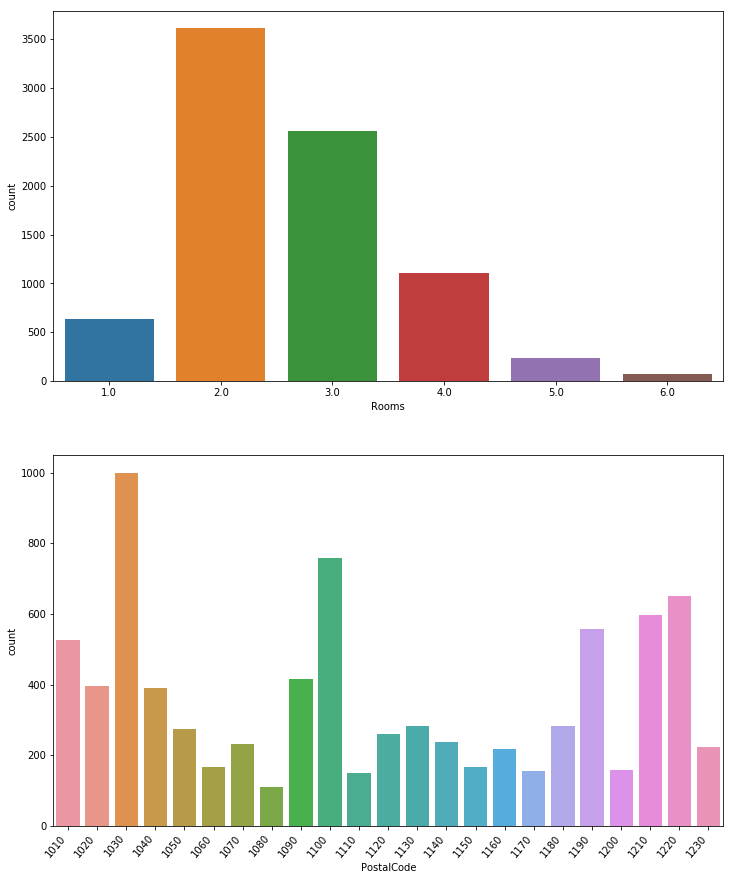

In [22]:
fig, ax =plt.subplots(2,1, figsize=(12,15))
sns.countplot(rental_properties['Rooms'], ax=ax[0])
sns.countplot(rental_properties['PostalCode'], ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=50, ha="right")

In [ ]:
sns.jointplot(x='Size', y='Price', data=rental_properties['Size','Price'])

In [24]:
vienna_districts = rental_properties[['PostalCode','District']].drop_duplicates().sort_values(by=['PostalCode']).reset_index(drop=True)
vienna_districts

,PostalCode,District
0,1010,Innere Stadt
1,1020,Leopoldstadt
2,1030,Landstraße
3,1040,Wieden
4,1050,Margareten
5,1060,Mariahilf
6,1070,Neubau
7,1080,Josefstadt
8,1090,Alsergrund
9,1100,Favoriten


In [25]:
latitude = np.zeros(vienna_districts.shape[0])
longitude = np.zeros(vienna_districts.shape[0])

geolocator = Nominatim(user_agent="vienna_explorer")

for idx in range(vienna_districts.shape[0]):
    address = vienna_districts['District'].loc[idx] + ', Wien'
    
    location = geolocator.geocode(address)
    latitude[idx] = location.latitude
    longitude[idx] = location.longitude

In [26]:
district_coordinates = vienna_districts
district_coordinates['Latitude'] = latitude
district_coordinates['Longitude'] = longitude
district_coordinates

,PostalCode,District,Latitude,Longitude
0,1010,Innere Stadt,48.209023,16.369851
1,1020,Leopoldstadt,48.200638,16.426895
2,1030,Landstraße,48.193644,16.396286
3,1040,Wieden,48.220210,16.371216
4,1050,Margareten,48.188073,16.353386
5,1060,Mariahilf,48.195475,16.347023
6,1070,Neubau,48.202264,16.349123
7,1080,Josefstadt,48.210852,16.347360
8,1090,Alsergrund,48.225073,16.358398
9,1100,Favoriten,48.152994,16.382822


In [27]:
# create map of Vienna using latitude and longitude values
map_vienna = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vienna)  
    
map_vienna